In [1]:
#Enable GPU use
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPus available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPus available:  1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [3]:
with open('features.pk', 'rb') as handle:
    data = pickle.load(handle)
#data = data.drop(columns=['MeetTijd','Length_MeetTijd','startTime','endTime'])

In [4]:
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
sm = SMOTE(random_state = 2) 


In [5]:
cols = data.columns
x = data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data = pd.DataFrame(x_scaled)
data.columns = cols

In [6]:
data

,IcNaOk,MeetTijd in seconds,Mean HR(bpm),Std HR(bpm),Max HR(bpm),Min HR(bpm),Mode HR(bpm),Median HR(bpm),Mean SpO2(%),Std SpO2(%),...,Max Sp*NIBP,Min Sp*NIBP,Mode Sp*NIBP,Median Sp*NIBP,Mean HR*Sp*NIBP,Std HR*Sp*NIBP,Max HR*Sp*NIBP,Min HR*Sp*NIBP,Mode HR*Sp*NIBP,Median HR*Sp*NIBP
0,0.0,0.191535,0.182784,0.382527,0.623762,0.336134,0.297872,0.106796,0.807914,0.356847,...,0.377844,0.005535,0.481757,0.286978,0.184963,0.361890,0.487468,0.003240,0.132029,0.123251
1,0.0,0.271186,0.245498,0.095441,0.198020,0.445378,0.425532,0.233010,0.853343,0.188262,...,0.240043,0.005244,0.575373,0.381177,0.264001,0.127748,0.137865,0.003745,0.213722,0.253748
2,0.0,0.235991,0.521027,0.188244,0.311881,0.537815,0.716312,0.567961,0.740494,0.342242,...,0.290773,0.005611,0.004384,0.203985,0.346698,0.499749,0.225658,0.004708,0.005715,0.309340
3,0.0,0.092896,0.229809,0.076698,0.183168,0.462185,0.411348,0.223301,0.809704,0.153266,...,0.245618,0.005549,0.635713,0.433753,0.258519,0.201038,0.146605,0.003638,0.237469,0.277547
4,0.0,0.220339,0.416532,0.120516,0.549505,0.563025,0.560284,0.407767,0.682715,0.355829,...,0.546824,0.005539,0.000214,0.379787,0.386654,0.446088,0.549388,0.004353,0.002026,0.384725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6120,1.0,0.076225,0.268510,0.087930,0.188119,0.453782,0.439716,0.262136,0.997319,0.031729,...,0.222405,0.440503,0.365087,0.124868,0.171652,0.137933,0.125695,0.307570,0.181319,0.140887
6121,1.0,0.120682,0.420870,0.179645,0.366337,0.546218,0.560284,0.398058,0.886442,0.376236,...,0.211026,0.432094,0.401515,0.099591,0.275607,0.227183,0.224028,0.364246,0.177437,0.223780
6122,1.0,0.115750,0.320658,0.108992,0.262376,0.478992,0.510638,0.320388,1.000000,0.000000,...,0.472746,0.457666,0.684795,0.436618,0.355420,0.281837,0.265238,0.305427,0.509369,0.346743
6123,1.0,0.115032,0.689754,0.168391,0.485149,0.764706,0.737589,0.655340,0.969292,0.169687,...,0.154130,0.411899,0.392104,0.074314,0.411937,0.233150,0.283784,0.505897,0.279319,0.358889


In [7]:
train, test = train_test_split(data, test_size=0.3)

In [8]:
X_train = train.drop(columns=['IcNaOk'])
y_train = train['IcNaOk']
X_test = test.drop(columns=['IcNaOk'])
y_test = test['IcNaOk']

In [9]:
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel()) 

In [10]:
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [11]:
model = tf.keras.Sequential([
    Dense(160, input_shape=(43,), activation='relu'), #second layer
    Dense(50, activation='relu'),
    Dense(2, activation='softmax') #gives probability of ICU admission
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160)               7040      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                8050      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 15,192
Trainable params: 15,192
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'], loss_weights=[1,10000])

In [15]:
model.fit(x=X_train_res, y=y_train_res, batch_size=10, epochs=40, verbose=2, validation_split=0.1) #class_weight={0:0.1,1:0.9} important

Epoch 1/40
691/691 - 3s - loss: 0.6084 - accuracy: 0.7050 - val_loss: 0.6250 - val_accuracy: 0.6992
Epoch 2/40
691/691 - 2s - loss: 0.5337 - accuracy: 0.7679 - val_loss: 0.6451 - val_accuracy: 0.6888
Epoch 3/40
691/691 - 2s - loss: 0.5047 - accuracy: 0.7848 - val_loss: 0.5000 - val_accuracy: 0.7812
Epoch 4/40
691/691 - 2s - loss: 0.4868 - accuracy: 0.7918 - val_loss: 0.6289 - val_accuracy: 0.7044
Epoch 5/40
691/691 - 2s - loss: 0.4775 - accuracy: 0.7950 - val_loss: 0.5600 - val_accuracy: 0.7565
Epoch 6/40
691/691 - 2s - loss: 0.4697 - accuracy: 0.7968 - val_loss: 0.6414 - val_accuracy: 0.6953
Epoch 7/40
691/691 - 2s - loss: 0.4637 - accuracy: 0.8010 - val_loss: 0.4901 - val_accuracy: 0.7773
Epoch 8/40
691/691 - 2s - loss: 0.4570 - accuracy: 0.8012 - val_loss: 0.4795 - val_accuracy: 0.7852
Epoch 9/40
691/691 - 2s - loss: 0.4522 - accuracy: 0.8057 - val_loss: 0.5309 - val_accuracy: 0.7552
Epoch 10/40
691/691 - 2s - loss: 0.4472 - accuracy: 0.8019 - val_loss: 0.5827 - val_accuracy: 0.7227

In [16]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=10)

184/184 [==============================] - 1s 2ms/step - loss: 0.3699 - accuracy: 0.8569


In [17]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.3698626756668091
Test accuracy: 0.8569096922874451


In [18]:
predictions = model.predict(x=X_test, batch_size=10,verbose=2)

184/184 - 0s


In [19]:
for i in predictions[1:10]:
    print(i)

[0.9836376  0.01636239]
[0.16434552 0.8356545 ]
[0.85080886 0.1491911 ]
[0.86579037 0.13420968]
[0.9922814  0.00771865]
[0.6576872  0.34231278]
[0.90609664 0.09390344]
[0.22168447 0.7783155 ]
[0.955483   0.04451701]


In [20]:
rounded_predictions = np.argmax(predictions,axis=-1)

In [21]:
rounded_predictions

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [22]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [23]:
cm = confusion_matrix(y_true = y_test, y_pred=rounded_predictions)

In [24]:
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]

    print(cm)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
        horizontalalignment="center",
        color="white" if cm[i,j]>thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[1442  201]
 [  62  133]]


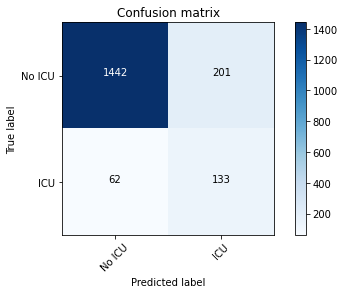

In [25]:
cm_plot_labels = ['No ICU','ICU']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion matrix')

In [26]:
from sklearn.metrics import roc_curve
y_pred_keras = np.argmax(model.predict(X_test),axis=-1).ravel()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [27]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [28]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

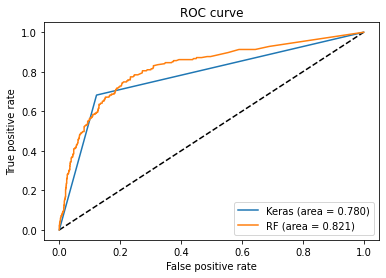

In [29]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

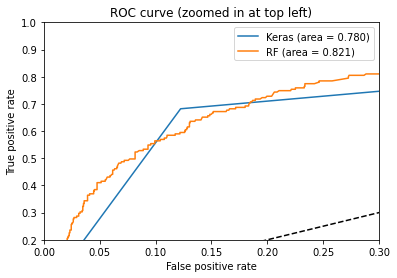

In [30]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.3)
plt.ylim(0.2, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()